<a href="https://colab.research.google.com/github/jlifferth/UQ-BIO-2022/blob/main/Module_3_3_TASEP_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASEP Modelling Notebook

----------
## Qbio Summer School 2022

--------------
```
Instructor: Will Raymond
Author: Will Raymond
Contact Info: wsraymon@rams.colostate.edu
```

<details>
  <summary>Copyright info</summary>

```
Copyright 2022 Brian Munsky

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```
<details>


**Abstract**

This notebook provides code to build and analyze TASEP (Total asymmetric exclusion process) models. TASEP models broadly can be thought of as modelling particles on 1D or 2D lattice where no two particles can occupy the same node in the lattice, i.e., the particles have physical properties and are tangible.


**Learning Objectives**

By the end of this notebook the student should be able to:

* Describe the simplest TASEP model
* Have intuition about different dynamic regimes and why they form
* Know what types of processes can be modelled by TASEP's
* Know when a TASEP is an appropriate model for certain processes

## Model Description

TASEP is a very generalized model that is used in many areas for simulating exclusion processes (processes that have volume and particles cannot occupy the same location as one another).

The canonical formulation consists of a lattice of length, L, nodes. Particles can enter one end of the lattice at a rate $\alpha$ (particles / time) and step from node to node in one direction at a stepping rate $k$ (nodes / second). Particles then leave the lattice at rate $\beta$ (particles / time). Particles occupy one node at a time and are **NOT** allowed to pass one another. 


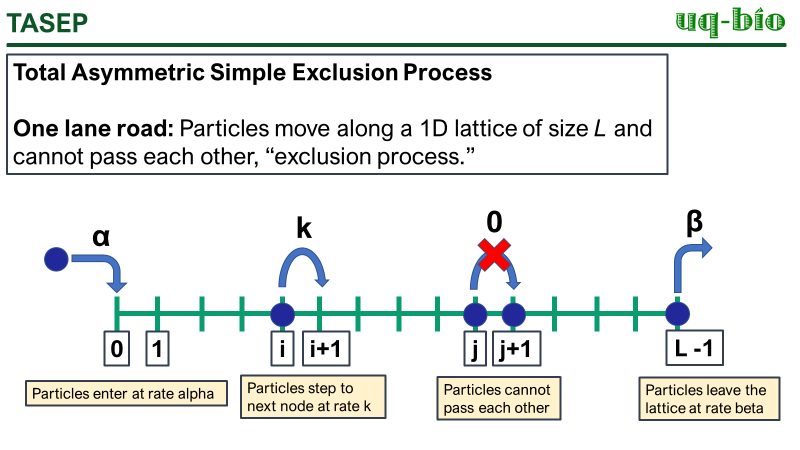

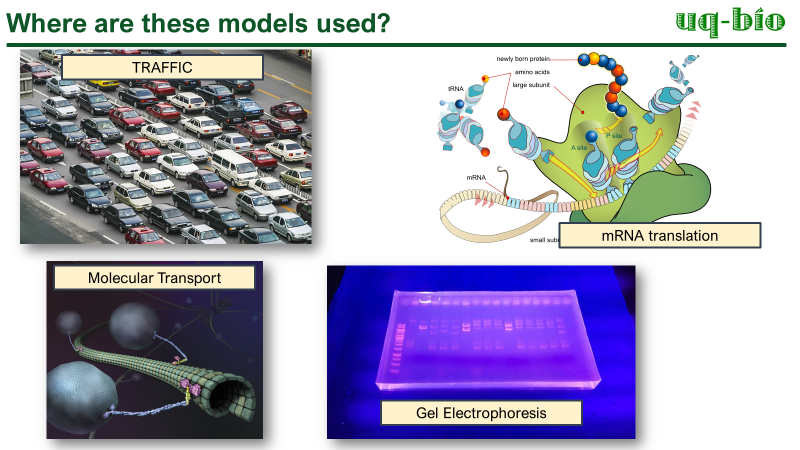


Let's consider a lattice of L = 4, with a 4 state vector $x$ corresponding to 0 for empty and 1 for occupied.

$$
x = 
\begin{bmatrix}
     & x_1 & x_2 & x_3 & x_4 
\end{bmatrix}
$$

so for a lattice with one particle at location three the state vector would look like:

$$
x = 
\begin{bmatrix}
     & 0 & 0 & 1 & 0 
\end{bmatrix}
$$

Lets formulate the Stoichiometry, logically we have:

$N_{rxns} = L+1$ that is to say, we have one for each step along the lattice til node $x_4$ (3 total), and one for the leaving reaction $\beta$ and one for the entering reaction $\alpha$


$$
S = 
\begin{bmatrix}
     & x_1 & x_2 & x_3 & x_4 \\ 
R_0: & 1, & 0, & 0, & 0 \\
R_1: & -1, & 1, & 0, & 0 \\
R_2: & 0, & -1, & 1, & 0 \\
R_3: & 0, & 0, & -1, & 1 \\
R_4: & 0, & 0, & 0, & -1
\end{bmatrix}
$$

$$
R_0 = \textrm{Entering the lattice}
$$
$$
R_1,R_2,R_3, = \textrm{Stepping forward one state}
$$
$$
R_4 = \textrm{Leaving the lattice}
$$

For the propensities we have to include an exclusion term for the state ahead of the current state. 

The rate stepping forward without exclusion is:

$$ k_i*x_i$$ 

And with the exclusion, if the state ahead is 1, the full rate is set to 0

$$ k_i * x_i* (1-x_{i+1}) $$

Putting that into the propensities:

$$
W = 
\begin{bmatrix}
     & propensity \\ 
R_0: &  \alpha * (1-x_1)\\
R_1: & k_1 * x_1 * (1-x_2)\\
R_2: & k_2 * x_2 * (1-x_3)\\
R_3: & k_3 * x_3 * (1-x_4)\\
R_4: & \beta * x_4
\end{bmatrix}
$$




In [1]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm.notebook as tq
from typing import Union

plt.rcParams['figure.dpi'] = 120

## 1D node lattice TASEP (Stoichiometry approach)

Lets write our code to use the stoichiometry and propensity matrices to simulate the TASEP

In [2]:
L = 5   #Length of the lattice
k_step = .3  #forward speed node/s
k_in = .5  #particle in rate 1/s
k_out = .5 #particle out rate 1/s

xi = np.zeros([1,L]).T  #initial condition, lattice is blank

def make_S_W(k_in : float, k_out : float, k_step : float, L : int):
  '''
  A function that builds our stoichiometry and propensities
  for a 1D TASEP lattice

  Parameters
  ----------
  k_in : float
    particle entering the lattice rate (1/s)
  k_out : float 
    particle leaving the lattice rate (1/s)
  k_step : float
    particle forward node speed (1/s)

  Returns
  -------
  S : 2d numpy array
    Stoichiometry matrix of L x nRxns (L+1)
  W : 2d numpy array
    Propensity matrix of nRxns x L
  W0 : 2d numpy array
    Propensity array for k_in of nRxns x L

  '''
  S = np.eye(L)*-1; W = np.eye(L)*k_step  ## a 1 diagonal stoich matrix
  np.fill_diagonal(S[1:,:],1)  # fill the off diagonal with -1

  # add the incoming rate for the first lattice location
  incoming_vec = np.zeros([L,1]) 
  incoming_vec[0] = 1
  S = np.hstack((incoming_vec,S))  # include the incoming rate

  incoming_propensity = np.zeros([1,L]) #the propensities
  incoming_propensity[0,0] = 0
  W = np.vstack([incoming_propensity, W])
  W[-1,-1] = k_out

  W0 = np.zeros([L+1,1])
  W0[0,0] = k_in  #initiation rate (not dependent on x)

  S = S.astype(int); #convert the stoich to integer
  return S,W,W0


In [3]:
def tasep_stoich(xi : Union[list, np.ndarray] ,S : np.ndarray, W1 : np.ndarray,
                 W0 : np.ndarray, time : Union[list, np.ndarray]):
    '''
    A function that runs a TASEP simulation for a given S, W and W0, 
    precalculating the stoichiometry and propensities

    Parameters
    ----------
    xi : 2darray (L x 1)
      initial condition for the lattice
    S : 2d numpy array
      Stoichiometry matrix of L x nRxns (L+1)
    W : 2d numpy array
      Propensity matrix of nRxns x L
    W0 : 2d numpy array
      Propensity array for k_in of nRxns x L
    time : 1d numpy array
      time vector to record

    Returns
    -------
    data : 2d numpy array
      lattice states array of shape (L x Timepoints)
    '''
    
    x=np.copy(xi) #x states
    t=0  #initial time point
    xshape=len(x)  #get the shape of our states
    data=np.zeros((len(xi),len(time)))  #allocate the data array to return
    record_iterator =0 # setup the iterator for the data recording
    tf = time[-1]  #get the final time point
    
    while t<tf:  #while the current time is less than the final time        
        rate=np.atleast_2d(np.dot(W1,x) + W0) #generate the propensities as if theres no exclusion      

        ##exclusion term, here we will manually set some of our rates to zero based on exclusion of states 
        # ahead of the x
        occupied_states  = x.T == 0 ## States that are == 1
        exclusion_bool = np.less(x[1:,0], x[:-1,0]).tolist() #get the logic for states that 
        # have a value of one behind them

        #here we now have boolean logic to include the stepping rates, we gotta add the ones for in and out

        if x[0,0] == 1: ## if the first state is occupied
          exclusion_bool = [False,] + exclusion_bool #this rate cannot be used
        else:
          exclusion_bool = [True,] + exclusion_bool # the in rate can be used

        if x[-1,0] == 1:
            exclusion_bool = exclusion_bool + [True,]  # the out rate can be used
        else:
            exclusion_bool = exclusion_bool + [False,]  # the out rate cannot be used
        
        ##multiply this boolean array by the rates for current propensities
        rate = np.multiply(rate,np.array([exclusion_bool]).T) 
        rate=np.cumsum(rate)   
        
        t=(t-np.log(np.random.rand(1))/rate[-1]) # Update the time point
        ro=rate[-1]*np.random.rand()  
        while t>time[record_iterator]: #fill the data array if we passed the next time points
            if t>tf: #if we passed the final time point, end the loop and return the data
                b = len(time[record_iterator:])
                fill = np.repeat(x,b) 
                data[:,record_iterator:]=fill.reshape(xshape,b)
                return data 
            else:
                data[:,record_iterator]=x.reshape(xshape)
                record_iterator=record_iterator+1
        for i in range(len(rate)): #pick the next reaction rate
            if rate[i]>=ro:
                event=i
                break
        x=x+np.atleast_2d(S[:,event]).T #update the state
    #return the final data
    return data

Stoich shape:
(12, 13)
Propensity shape:
(13, 12)


Text(0, 0.5, 'Time')

<Figure size 1200x800 with 0 Axes>

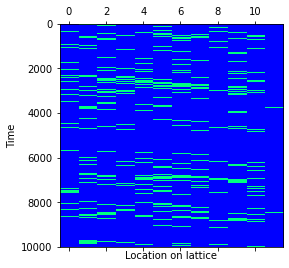

In [18]:
L = 12 #@param slider {type:"slider", min:3, max:100, step:1}
kin = .005
kout = .3 #1/s
kstep = .05 #1/s

# get our stoichiometry and propensity matrices
S,W,W0 = make_S_W(kin,kout,kstep,L) 

print('Stoich shape:')
print(S.shape)
print('Propensity shape:')
print(W.shape)

xi = np.zeros([1,L]).T
t = np.linspace(0,10001,10001)
traj = tasep_stoich(xi,S,W,W0,t)
plt.figure(dpi=200)
plt.matshow(traj.T,aspect = L/len(t), cmap='winter')
plt.xlabel('Location on lattice')
plt.ylabel('Time')


### How bout some predicted statistics?
 
We can get the derive the average speed and dwell time from the parameters:
 
If one step along the lattice the dwell time happens at $k_{step}$, then the time spent in lattice nodes on average is $(\sum_i^{L-1} \frac{1}{k_{step}}) + \frac{1}{k_{out}}$. The final leaving rate also has to be included separately in our case.
 
To get the average elongation rate we similarly divide the length of the lattice by the average dwell time (distance/time). 
 

In [19]:
tau = ((L-1)*(1/kstep) + (1/kout))   #time spent in lattice
ke_av = L/tau #total nodes / time spent in all nodes = speed
print('time spent in system: %fs'%tau)
print('average speed %f nodes/s'%ke_av)

time spent in system: 223.333333s
average speed 0.053731 nodes/s


We can also calculate occupation probabilities and compare to the analytical average occupation (rate in * time spent in system)

In [20]:
occup = np.mean(traj[:,::100]) # average state occupation 
density = occup*L  #average state occupation * number nodes in lattice = density
analytical_density = kin * tau # whats the predicted density?

print('average occupation per node: %f percent'%occup)
print('simulation density %f particles'%density)
print('analytical density %f particles'%analytical_density)

average occupation per node: 0.107261 percent
simulation density 1.287129 particles
analytical density 1.116667 particles


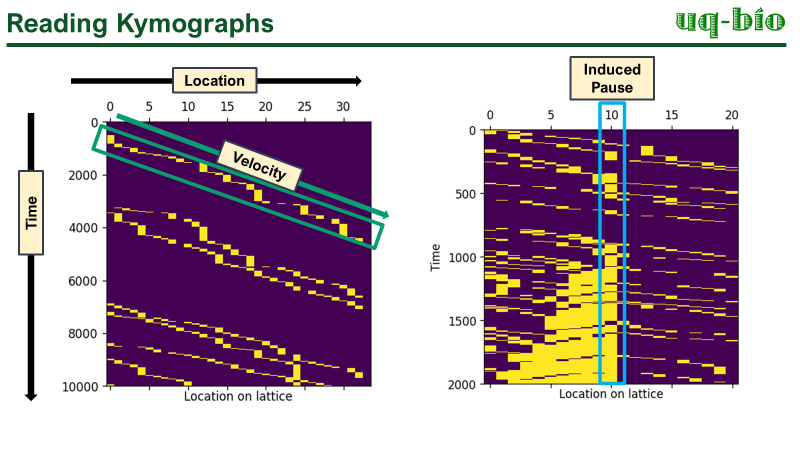

## As we go building Stoich/Prop Approach

Where each iteration we build the possible reactions that can happen.

In [21]:
def tasep_traj(xi : np.ndarray, kin : float, kout : float, 
               kstep : float, time_vector : Union[list, np.ndarray]):
  '''
  A function that runs a TASEP simulation and builds the needed S and W based 
  on current state, and does the logic a little more straightforward
  
  Parameters
  ----------
  xi : 1darray (L)
    initial condition for the lattice
  kin : float
    particle entering the lattice rate (1/s)
  kout : float 
    particle leaving the lattice rate (1/s)
  kstep : float
    particle forward node speed (1/s)
  time_vector : 1d numpy array
    time vector to record

  Returns
  -------
  traj_data : 2d numpy array
    lattice states array of shape (L x Timepoints)
  '''
  total_states = np.max(xi.shape) #get total states
  x = np.copy(xi)  #set the state to initial state
  t = 0 
  record_index = 0
  traj_data = np.zeros((total_states, len(time_vector)))
  
  while t < time_vector[-1]:  #while time is less than last time point
    #lets set up the current propensities as such:
    # N available molecules to step, kin, kout
    propensity = []
    occupied_states = np.where(x!=0)[0]
    available_to_step_forward = []
    for state in occupied_states:  #find the molecules that arent blocked from moving forward
      if state != L-1:
        if x[state+1] == 0:
          available_to_step_forward = available_to_step_forward + [state, ]

    propensity = [kstep,]*len(available_to_step_forward)  #build the propensity list
    propensity = propensity + [0,0]
    if x[0] == 0:
      propensity[-2] = kin
    if x[-1] !=0:
      propensity[-1] = kout   #append the kin/kout, set to 0 if blocked

    cumulative_prop = np.cumsum(propensity) #calculate next time to reaction
    time_next_reaction = -np.log(np.random.rand(1)) / np.sum(propensity) 

    t += time_next_reaction
 
    while t >= time_vector[record_index]:  #if time passed the record vector, record the state
      traj_data[:,record_index] = x
      record_index += 1
      if time_vector[record_index] == time_vector[-1]:   #if its moved past the final time point, end and return the data
        traj_data[:,record_index] = x
        return traj_data

    #Select the new reaction to happen based on current state
    random_rate = np.random.rand()*np.sum(propensity)
    nprop = len(propensity)  #how many propensities are there currently
    for i in range(len(propensity)):
      if cumulative_prop[i] >= random_rate:
        reaction_id = i
        break

    if reaction_id < nprop-2:  #if the reaction isnt the last too, its something that stepped
      x[available_to_step_forward[reaction_id]] = 0  #molecule moved forward
      x[available_to_step_forward[reaction_id] + 1] = 1
    if reaction_id == nprop-1: #molecule left system
      x[-1] = 0
    if reaction_id == nprop-2:  #molecule came in the system
      x[0] = 1

Text(0, 0.5, 'Time')

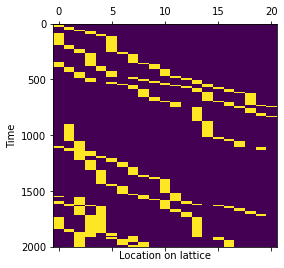

In [22]:
L = 21 #@param slider {type:"slider", min:3, max:100, step:1}
kin = .008
kout = .5
kstep = .05

t = np.linspace(0,1000,2001)

xi =np.zeros(L)
traj = tasep_traj(xi,kin,kout,kstep,t)
plt.matshow(traj.T,aspect = L/len(t))
plt.xlabel('Location on lattice')
plt.ylabel('Time')

## Agent based approach to record all steps

In [23]:
class TASEP_particle():
  '''
  Container object for particles and their steps they took
  '''
  def __init__(self, id, loc, ti):
    self.action_list = [] # actions taken
    self.id = id          # particle id
    self.loc = loc        # particle locations
    self.record(ti)       # start the recorder

  def record(self, action_time):
    # Store the location and time in the action list
    self.action_list.append([self.loc, action_time])

  def finalize_actions(self):
    # convert the action list to a numpy array
    self.actions_array = np.array(self.action_list)
  
  def compress_actions(self):
    # Convoluted code that compresses the final list of steps into the format:
    # to the format [loc1, start time,  loc1, stop time,  loc2, start time, loc2, stop time ..... locn, start time, locn, stop time]
    # Basically we only need the start and stop times that the particle stayed in any given lattice location
    # since we know we record when we step, each time step is known in this case as long as its worked back out of the list of 
    # actions.
    loc = 0
    action_list = [] # new action list
    max_lattice = int(np.max(self.actions_array[:,0]))+1  #for every lattice id
    for i in range(max_lattice):  #for every lattice id
      if np.sum(self.actions_array[:,0] == i) >= 1: # was the particle in this location (important for initial conditions)
        segment = self.actions_array[self.actions_array[:,0] == i][(0,-1),:] # get first and last actions at a given location
        if i != max_lattice-1:   # as long as we are not in the last location
          segment[1,1] = self.actions_array[self.actions_array[:,0] == i+1][0,1]  # overwrite last action time to the step to node + 1
        action_list.append(segment) # append the segment
    self.actions_array_comp = np.array(action_list).reshape(np.array(action_list).shape[0]*2,2)  #reshape the array and store it
    


def tasep_traj_agents(xi : np.ndarray, kin : float, kout : float, kstep : float, time_vector : Union[list, np.ndarray]):
  '''
  A function that runs a TASEP simulation using an agent based approach,
  our code will create new agents and retain a list of agents to return to the
  user. Each particle will retain a list of the steps and th time they took them.
  
  Parameters
  ----------
  xi : 1darray (L)
    initial condition for the lattice
  kin : float
    particle entering the lattice rate (1/s)
  kout : float 
    particle leaving the lattice rate (1/s)
  kstep : float
    particle forward node speed (1/s)
  time_vector : 1d numpy array
    time vector to record

  Returns
  -------
  traj_data : 2d numpy array
    lattice states array of shape (L x Timepoints)
  '''
  particle_id = 0 # particle counter
  agent_pool = [] #initalize our current agent list
  finished_agents = [] #initalize our finalized agents (agents who left the lattice)
  t = 0  # set time to 0 
  
  L = np.max(xi.shape) #get total states

  # initalize the agent pool based on inital condition
  for i in range(L):
    if xi[i] == 1:
      agent_pool.append(TASEP_particle(particle_id, i, 0)) # make a new particle
      particle_id +=1 #increment counter

  while t < time_vector[-1]:  # while time is less than last time point
    propensity = []           # build our propensities
    occupied_locations = [agent.loc for agent in agent_pool] #get all agent locations
    for agent in agent_pool:
      if agent.loc + 1 not in occupied_locations and agent.loc != L-1: #if the states ahead are free and not at the last node
        propensity.append(kstep)  #add kstep
      else:
        propensity.append(0)  #otherwise add zero

    # handle the kin / kout rates
    propensity = propensity + [0,0]  
    if 0 not in occupied_locations:
      propensity[-2] = kin
    if L-1 in occupied_locations:
      propensity[-1] = kout   #append the kin/kout, set to 0 if blocked

    cumulative_prop = np.cumsum(propensity) #calculate next time to reaction
    time_next_reaction = (-np.log(np.random.rand(1)) / np.sum(propensity))[0] 
    t += time_next_reaction

    #Select the new reaction to happen based on current state
    random_rate = np.random.rand()*np.sum(propensity)
    nprop = len(propensity)  #how many propensities are there currently
    for i in range(len(propensity)):
      if cumulative_prop[i] >= random_rate:
        reaction_id = i
        break

    if reaction_id < nprop-2:  #if the reaction isnt the last two, its something that stepped
      agent_pool[reaction_id].loc +=1  #molecule moved forward
    if reaction_id == nprop-1: #molecule left system
      finished_agents.append(agent_pool[-1]) #remove the last agent (one on last node)
      agent_pool = agent_pool[:-1]
    if reaction_id == nprop-2:  #molecule came in the system
      agent_pool = [TASEP_particle(particle_id, 0, t),] + agent_pool # add an agent to our list
      particle_id += 1
    
    for agent in agent_pool:  # update the record counter for all particles
      agent.record(t)

  # we have passed the final time, collect all agents 
  all_agents = finished_agents + agent_pool 

  # finalize all the agents action arrays
  for agent in all_agents:
    agent.finalize_actions() # converts agents action lists to an array
    agent.compress_actions() # compresses that array to remove unnecessary times and steps
  return all_agents  #give me a list of all the agents back

    

In [24]:
L = 21 #@param slider {type:"slider", min:3, max:100, step:1}
kin = .03
kout = .5
kstep = .5

t = np.linspace(0,1000,2001)

xi =np.zeros(L)

particles = tasep_traj_agents(xi,kin,kout,kstep,t)

(0.0, 20.0)

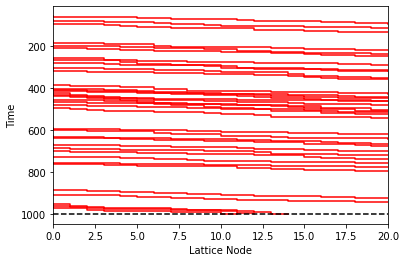

In [25]:
[plt.plot(p.actions_array_comp[:,0].astype(int),p.actions_array_comp[:,1],'r' ) for p in particles]
plt.gca().invert_yaxis()
plt.plot([0,L-1],[t[-1],t[-1]],'k--')
plt.ylabel('Time')
plt.xlabel('Lattice Node')
plt.xlim([0,L-1])

### Model comparisons

Which one was the better approach in this case?

In [27]:
L = 17 #@param slider {type:"slider", min:3, max:100, step:1}
kin = .03
kout = .05
kstep = 1
t = np.linspace(0,1000,1001)
import time
xi_agent = np.zeros(L)
xi_stoich = np.zeros([1,L]).T
S,W,W0 = make_S_W(kin,kout,kstep,L)

st = time.time()
for i in range(500):
  traj = tasep_traj(xi_agent,kin,kout,kstep,t)
time_as_we_go = time.time() -st

st = time.time()
for i in range(500):
  traj = tasep_stoich(xi_stoich,S,W,W0,t)
time_stoich = time.time() -st

st = time.time()
for i in range(500):
  traj = tasep_traj_agents(xi_agent,kin,kout,kstep,t)
time_agent = time.time() -st

print("Time Simulating as we go building propensities:")
print(time_as_we_go)
print("Time Simulating with preallocated Stoich/prop:")
print(time_stoich)
print("Time Simulating with agent based approach:")
print(time_agent)


Time Simulating as we go building propensities:
14.826748371124268
Time Simulating with preallocated Stoich/prop:
13.694497346878052
Time Simulating with agent based approach:
17.257216691970825


## TASEP extensions

Now that we have examined the canonical simplest TASEP, what are some extensions to this model to capture some more realistic dynamics?

* Multiple Lanes!
  * Multilane highways
  * Multiple line queues (grocery shopping)
  * Microtubule transport

* Variable Stepping Rates
  * mRNA translation, codons can have different rates
  * Speed limit changes
  * Resource limited stepping

* Variable Particle Sizes
  * mRNA translation, ribosomes take up a footprint of 9 codons!

* Langmuir Kinetics (Particles can join and leave at any point)
  * Surface adsorption
  * IRES sites on mRNA

* 2D Lattices




### TASEP with induced pause

Lets add an arbitrary pause site with a different stepping rate, this will cause a traffic jam to build if the stepping rate is slower than the surrounding ones.

In [28]:
def tasep_traj_pause(xi : np.ndarray, kin : float, kout : float,
                     kstep : float, pause_location : int, pause_rate : float, time_vector : Union[list, np.ndarray]):
  '''
  A function that runs a TASEP simulation and builds the needed S and W based 
  on current state, and does the logic a little more straightforward
  
  Parameters
  ----------
  xi : 1darray (L)
    initial condition for the lattice
  kin : float
    particle entering the lattice rate (1/s)
  kout : float 
    particle leaving the lattice rate (1/s)
  kstep : float
    particle forward node speed (1/s)
  time_vector : 1d numpy array
    time vector to record

  Returns
  -------
  traj_data : 2d numpy array
    lattice states array of shape (L x Timepoints)
  '''
  total_states = np.max(xi.shape) #get total states
  x = np.copy(xi)  #set the state to initial state
  t = 0 
  record_index = 0
  traj_data = np.zeros((total_states, len(time_vector)))
  
  while t < time_vector[-1]:  #while time is less than last time point

    #lets set up the current propensities as such:
    # N available molecules to step, kin, kout
    propensity = []
    occupied_states = np.where(x!=0)[0]
    available_to_step_forward = []
    for state in occupied_states:  #find the molecules that arent blocked from moving forward
      if state != L-1:
        if x[state+1] == 0:
          available_to_step_forward = available_to_step_forward + [state, ]

    propensity = [kstep,]*len(available_to_step_forward)  #build the propensity list
    propensity = propensity + [0,0]
    if x[0] == 0:
      propensity[-2] = kin
    if x[-1] !=0:
      propensity[-1] = kout   #append the kin/kout, set to 0 if blocked

##################### NEW ##############################

    ## induce a pause at the pause location
    m = 0
    for state in occupied_states:  
      if state != L-1:
        if x[state+1] == 0:
          if state == pause_location:
            propensity[m] = pause_rate
          m+=1

########################################################

    cumulative_prop = np.cumsum(propensity) #calculate next time to reaction
    time_next_reaction = -np.log(np.random.rand(1)) / np.sum(propensity) 

    t += time_next_reaction
    
    while t >= time_vector[record_index]:  #if time passed the record vector, record the state
      traj_data[:,record_index] = x
      record_index += 1
      if time_vector[record_index] == time_vector[-1]:   #if its moved past the final time point, end and return the data
        traj_data[:,record_index] = x
        return traj_data

    #Select the new reaction to happen based on current state
    random_rate = np.random.rand()*np.sum(propensity)
    nprop = len(propensity)  #how many propensities are there currently
    for i in range(len(propensity)):
      if cumulative_prop[i] >= random_rate:
        reaction_id = i
        break

    if reaction_id < nprop-2:  #if the reaction isnt the last too, its something that stepped
      x[available_to_step_forward[reaction_id]] = 0  #molecule moved forward
      x[available_to_step_forward[reaction_id] + 1] = 1
    if reaction_id == nprop-1: #molecule left system
      x[-1] = 0
    if reaction_id == nprop-2:  #molecule came in the system
      x[0] = 1

Text(0, 0.5, 'Time')

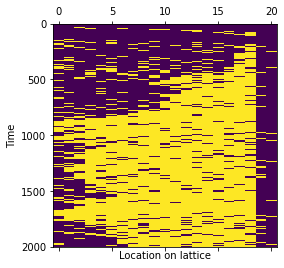

In [29]:
L = 21 #@param slider {type:"slider", min:3, max:100, step:1}
kin = .03 #@param slider {type:"slider", min:0.01, max:0.1, step:0.01}
kout = .5   #@param slider {type:"slider", min:0.01, max:0.5, step:0.01}
kstep = .2  #@param slider {type:"slider", min:0.01, max:0.5, step:0.01}
kpause = 0.02 #@param slider {type:"slider", min:0.01, max:0.2, step:0.01}
pause_location = 18 #@param slider {type:"slider", min:3, max:100, step:1}

t = np.linspace(0,4000,2001)

xi =np.zeros(L)
traj = tasep_traj_pause(xi,kin,kout,kstep, pause_location, kpause,t)
plt.matshow(traj.T,aspect = L/len(t))
plt.xlabel('Location on lattice')
plt.ylabel('Time')

### TASEP with arbitrary stepping rates

Lets reformulate our code to allow for a different stepping rate at every location along the lattice!

In [30]:
def tasep_traj_arbitrary_rates(xi : np.ndarray, kin : float, kout : float, ksteps : float, time_vector : Union[list, np.ndarray]):
  '''
  A function that runs a TASEP simulation and builds the needed S and W based 
  on current state, and does the logic a little more straightforward
  
  Parameters
  ----------
  xi : 1darray (L)
    initial condition for the lattice
  kin : float
    particle entering the lattice rate (1/s)
  kout : float 
    particle leaving the lattice rate (1/s)
  kstep : float
    particle forward node speed (1/s)
  time_vector : 1d numpy array
    time vector to record

  Returns
  -------
  traj_data : 2d numpy array
    lattice states array of shape (L x Timepoints)
  '''
  total_states = np.max(xi.shape) #get total states
  x = np.copy(xi)  #set the state to initial state
  t = 0 
  record_index = 0
  traj_data = np.zeros((total_states, len(time_vector)))
  
  while t < time_vector[-1]:  #while time is less than last time point

    #lets set up the current propensities as such:
    # N available molecules to step, kin, kout
    propensity = []
    occupied_states = np.where(x!=0)[0]
    available_to_step_forward = []
    for state in occupied_states:  #find the molecules that arent blocked from moving forward
      if state != L-1:
        if x[state+1] == 0:
          available_to_step_forward = available_to_step_forward + [state, ]

          ##################### NEW ##############################
          propensity = propensity + [ksteps[state],]  #build the propensity list
          ########################################################

    propensity = propensity + [0,0]
    if x[0] == 0:
      propensity[-2] = kin
    if x[-1] !=0:
      propensity[-1] = kout   #append the kin/kout, set to 0 if blocked


    cumulative_prop = np.cumsum(propensity) #calculate next time to reaction
    time_next_reaction = -np.log(np.random.rand(1)) / np.sum(propensity) 

    t += time_next_reaction
    
    while t >= time_vector[record_index]:  #if time passed the record vector, record the state
      traj_data[:,record_index] = x
      record_index += 1
      if time_vector[record_index] == time_vector[-1]:   #if its moved past the final time point, end and return the data
        traj_data[:,record_index] = x
        return traj_data

    #Select the new reaction to happen based on current state
    random_rate = np.random.rand()*np.sum(propensity)
    nprop = len(propensity)  #how many propensities are there currently
    for i in range(len(propensity)):
      if cumulative_prop[i] >= random_rate:
        reaction_id = i
        break

    if reaction_id < nprop-2:  #if the reaction isnt the last too, its something that stepped
      x[available_to_step_forward[reaction_id]] = 0  #molecule moved forward
      x[available_to_step_forward[reaction_id] + 1] = 1
    if reaction_id == nprop-1: #molecule left system
      x[-1] = 0
    if reaction_id == nprop-2:  #molecule came in the system
      x[0] = 1

Text(0, 0.5, 'Time')

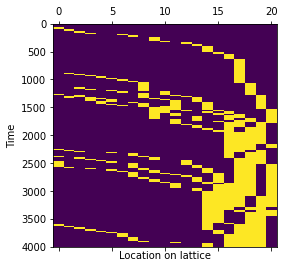

In [35]:
L = 21 #@param slider {type:"slider", min:3, max:100, step:1}
kin = 0.005   #@param slider {type:"slider", min:0.001, max:0.5, step:0.001}
kout = 0.006  #@param slider {type:"slider", min:0.001, max:0.5, step:0.001}

ksteps = np.linspace(.1,.001,L).tolist()

t = np.linspace(0,2000,4001)

xi =np.zeros(L)
traj = tasep_traj_arbitrary_rates(xi,kin,kout,ksteps,t)
plt.matshow(traj.T,aspect = L/len(t))
plt.xlabel('Location on lattice')
plt.ylabel('Time')

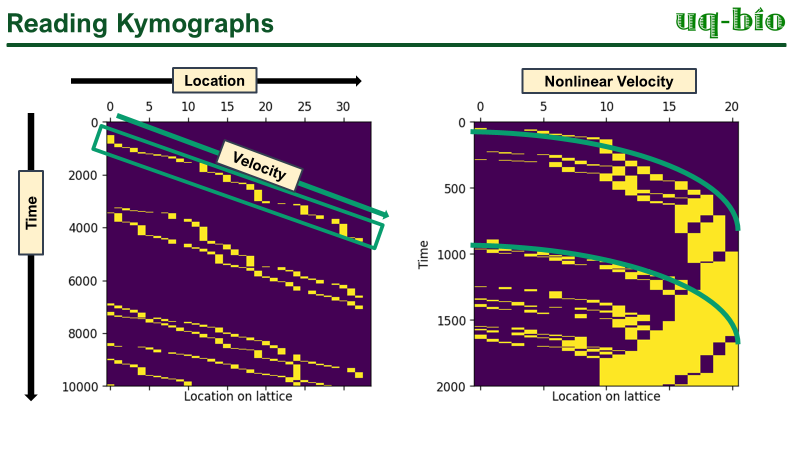

### TASEP with arbitrary particle sizes

To allow for exclusion of any size, we have to update our propensity formulation to include all states of i+1 to i+R 

$$ k_i * x_i* (1-x_{i+1})*(1-x_{i+2})*...(1-x_{i+R}) $$

Generic exclusion logic for propensities for an exclusion radius of $R$: 

$$ k_i * x_i* \prod_{j = (i+1)}^{j = R}(1-x_{j}) $$


In [36]:
def tasep_traj_ex(xi, kin, kout, kstep, time_vector, exclusion=10):
  '''
  A function that runs a TASEP simulation and builds the needed S and W based 
  on current state, and does the logic a little more straightforward
  
  Parameters
  ----------
  xi : 1darray (L)
    initial condition for the lattice
  kin : float
    particle entering the lattice rate (1/s)
  kout : float 
    particle leaving the lattice rate (1/s)
  kstep : float
    particle forward node speed (1/s)
  time_vector : 1d numpy array
    time vector to record
  exclusion: integer
    size of particles in units of nodoes, optional, default = 10

  Returns
  -------
  traj_data : 2d numpy array
    lattice states array of shape (L x Timepoints)
  total_particles : intger
    total particles that passed the system
  '''
  total_particles = 0
  total_states = np.max(xi.shape) #get total states
  x = np.copy(xi)  #set the state to initial state
  t = 0 
  record_index = 0
  traj_data = np.zeros((total_states, len(time_vector)))

  while t < time_vector[-1]:  #while time is less than last time point
    #lets set up the current propensities as such:
    # N available molecules to step, kin, kout
    propensity = []
    occupied_states = np.where(x!=0)[0] ## get the x states where there is a particle

    available_to_step_forward = []
    free_ahead = (occupied_states[1:]-occupied_states[:-1]) > exclusion #boolean logic if the state ahead is occupied for each 
    free_ahead = free_ahead.tolist() + [True,] # add one to the last one

    available_to_step_forward = [occupied_states[m] for m in range(len(occupied_states)) if free_ahead[m]] #record the ones to step forward if available

    propensity = []
    if len(available_to_step_forward) > 0:
      if available_to_step_forward[-1] != L-1: #if the last node is not occupied
        propensity = [kstep,]*len(available_to_step_forward)  #build the propensity list
      else:  #otherwise delete one of the forward rates and we need to add the kout
        propensity = [kstep,]*(len(available_to_step_forward)-1)  #build the propensity list

    propensity = propensity + [0,0]

##################### NEW ##############################
    if np.sum(x[0:exclusion]) == 0:  #if the first node is free add kin
      propensity[-2] = kin  
    if x[-1] !=0:  #if the final state is occupied add a propensity for leaving the system
      propensity[-1] = kout   #append the kin/kout, set to 0 if blocked

    cumulative_prop = np.cumsum(propensity) #calculate next time to reaction
    time_next_reaction = -np.log(np.random.rand(1)) / np.sum(propensity) 
##################### NEW ##############################


    t += time_next_reaction
    
    while t >= time_vector[record_index]:  #if time passed the record vector, record the state
      traj_data[:,record_index] = x
      record_index += 1
      if time_vector[record_index] == time_vector[-1]:   #if its moved past the final time point, end and return the data
        traj_data[:,record_index] = x
        return traj_data, total_particles

    #Select the new reaction to happen based on current state
    random_rate = np.random.rand()*np.sum(propensity)
    nprop = len(propensity)  #how many propensities are there currently
    for i in range(len(propensity)):
      if cumulative_prop[i] >= random_rate:
        reaction_id = i
        break

    if reaction_id < nprop-2:  #if the reaction isnt the last too, its something that stepped
      x[available_to_step_forward[reaction_id]] = 0  #molecule moved forward
      x[available_to_step_forward[reaction_id] + 1] = 1
    if reaction_id == nprop-1: #molecule left system
      x[-1] = 0
      total_particles +=1
    if reaction_id == nprop-2:  #molecule came in the system
      x[0] = 1

Text(0, 0.5, 'Time')

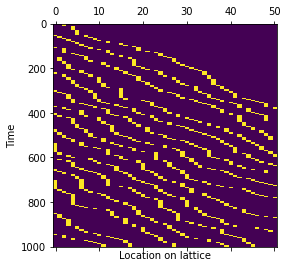

In [37]:
L =51 #@param slider {type:"slider", min:3, max:100, step:1}
kin = 0.081 #@param slider {type:"slider", min:0.001, max:0.5, step:0.01}
kout = 0.171 #@param slider {type:"slider", min:0.001, max:0.5, step:0.01}
kstep = 0.161 #@param slider {type:"slider", min:0.001, max:0.5, step:0.01}
exclusion = 6 #@param slider {type:"slider", min:1, max:50, step:1}


t = np.linspace(0,1000,1001)
xi =np.zeros(L)

traj,n_particles = tasep_traj_ex(xi,kin,kout,kstep,t,exclusion=exclusion)
plt.matshow(traj.T,aspect = L/len(t))
plt.xlabel('Location on lattice')
plt.ylabel('Time')

### TASEP that allows forward and backwards rates

Here is another extension that just doubles the rates and adds a backwards direction

In [38]:
def tasep_traj_both_directions(xi, kin,kout,kstep,k_backwards,kout_backwards,time_vector,exclusion=10):
  '''
  A function that runs a TASEP simulation and builds the needed S and W based 
  on current state, and does the logic a little more straightforward, allows forward and back rates
  
  Parameters
  ----------
  xi : 1darray (L)
    initial condition for the lattice
  kin : float
    particle entering the lattice rate (1/s)
  kout : float 
    particle leaving the lattice rate (1/s)
  kstep : float
    particle forward node speed (1/s)
  k_backwards : float
    particle rate to move backwards (1/s)
  kout_backwards : float
    particle rate to leave out node 0 (1/s)
  time_vector : 1d numpy array
    time vector to record
  exclusion: integer
    size of particles in units of nodoes, optional, default = 10

  Returns
  -------
  traj_data : 2d numpy array
    lattice states array of shape (L x Timepoints)
  total_particles : intger
    total particles that passed the system
  '''
  total_particles = 0
  total_states = np.max(xi.shape) #get total states
  x = np.copy(xi)  #set the state to initial state
  t = 0 
  record_index = 0 
  traj_data = np.zeros((total_states, len(time_vector))) #preallocate the simulation matrix
  occupied_states = np.where(x!=0)[0]
  while t < time_vector[-1]:  #while time is less than last time point
    #lets set up the current propensities as such:
    # N available molecules to step, kin, kout

    occupied_states = np.where(x!=0)[0]

    ## Forward rates
    available_to_step_forward = [] 
    free_ahead = (occupied_states[1:]-occupied_states[:-1]) > exclusion #check for all exclusion in the forward direction
    free_ahead = free_ahead.tolist() + [True,] #get a boolean list of which lattices are free
    available_to_step_forward = [occupied_states[m] for m in range(len(occupied_states)) if free_ahead[m]]
    forward_propensity = []
    if len(available_to_step_forward) > 0: #for each particle available to step forward, add a kstep rate
      if available_to_step_forward[-1] != L-1:
        forward_propensity = [kstep,]*len(available_to_step_forward)  #build the propensity list
      else:
        forward_propensity = [kstep,]*(len(available_to_step_forward)-1)  #build the propensity list

    ##backward rates
    available_to_step_backwards = []
    free_behind = (occupied_states[1:]-occupied_states[:-1]) > exclusion #check for all exclusion in the backwards direction
    free_behind = [True,] + free_behind.tolist() 
    available_to_step_backwards= [occupied_states[m] for m in range(len(occupied_states)) if free_behind[m]]
    backwards_propensity = []
    
    if len(available_to_step_backwards) > 0:
      if available_to_step_backwards[0] != 0:
        backwards_propensity = [k_backwards,]*len(available_to_step_backwards)  #build the propensity list
      else:
        backwards_propensity = [k_backwards,]*(len(available_to_step_backwards)-1)  #build the propensity list
    n_forwards = len(forward_propensity)
    n_backwards = len(backwards_propensity)

    available_to_step_backwards = available_to_step_backwards[::-1]
    propensity = forward_propensity + backwards_propensity + [0,0,0] #all potential reactions this step

    # add the kin and kout in both directions
    if np.sum(x[0:exclusion]) == 0:
      propensity[-3] = kin
    if x[-1] !=0:
      propensity[-2] = kout   #append the kin/kout, set to 0 if blocked
    if x[0] == 1:
      propensity[-1] = kout_backwards  

    cumulative_prop = np.cumsum(propensity) #calculate next time to reaction
    time_next_reaction = -np.log(np.random.rand(1)) / np.sum(propensity) 

    t += time_next_reaction
    
    while t >= time_vector[record_index]:  #if time passed the record vector, record the state
      traj_data[:,record_index] = x
      record_index += 1
      if time_vector[record_index] == time_vector[-1]:   #if its moved past the final time point, end and return the data
        traj_data[:,record_index] = x
        return traj_data, total_particles

    #Select the new reaction to happen based on current state
    random_rate = np.random.rand()*np.sum(propensity)
    nprop = len(propensity)  #how many propensities are there currently
    for i in range(len(propensity)):
      if cumulative_prop[i] >= random_rate:
        reaction_id = i
        break

    if reaction_id < nprop-3:  #if the reaction isnt the last too, its something that stepped
      if reaction_id < n_forwards:
        x[available_to_step_forward[reaction_id]] = 0  #molecule moved forward
        x[available_to_step_forward[reaction_id] + 1] = 1
       
      else:
        x[available_to_step_backwards[reaction_id-n_forwards]] = 0  #molecule moved backwards
        x[available_to_step_backwards[reaction_id-n_forwards] - 1] = 1

    if reaction_id == nprop-2: #molecule left system to the right
      x[-1] = 0
      total_particles +=1
    if reaction_id == nprop-3:  #molecule came in the system
      x[0] = 1
      
    if reaction_id == nprop-1: #molecule left system to the left
      x[0] = 0
    

Text(0, 0.5, 'Time')

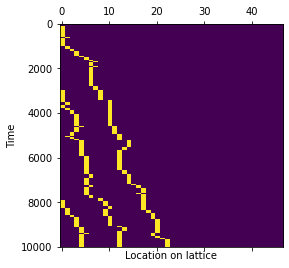

In [44]:
L =47 #@param slider {type:"slider", min:3, max:100, step:1}
kin = 0.121 #@param slider {type:"slider", min:0.001, max:0.5, step:0.01}
kout = 0.231 #@param slider {type:"slider", min:0.001, max:0.5, step:0.01}
kstep = 0.031 #@param slider {type:"slider", min:0.001, max:0.5, step:0.01}
kback = 0.011 #@param slider {type:"slider", min:0.001, max:0.5, step:0.01}
kout_back = 0.001 #@param slider {type:"slider", min:0.001, max:0.5, step:0.01}
exclusion = 7 #@param slider {type:"slider", min:1, max:15, step:1}

t = np.linspace(0,1000,1001)
xi =np.zeros(L)

def get_lattice_density(traj_soln):
  return np.mean(traj_soln,axis=1)
t = np.linspace(0,1000,10001)
traj,n_particles = tasep_traj_both_directions(xi,kin,kout,kstep,kback,kout_back,t,exclusion=exclusion)
plt.matshow(traj.T,aspect = L/len(t))
plt.xlabel('Location on lattice')
plt.ylabel('Time')

## Domains and Phase diagrams


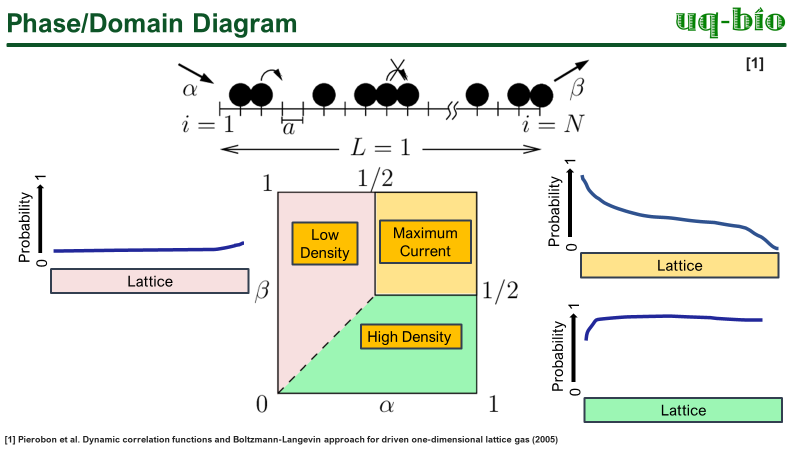

Canonical Taseps have 3 domain regimes, we can return to the metaphor of a highway as a way to visualize these regimes. 

A stretch of highway can be in 3 states:

* No traffic / low traffic (low density, unencumbered velocity)
* Traffic jam (maximum density, slow velocity)
* High traffic but fast (maximum flow of cars, everyone going similar velocity at high density)

These correspond to the domains described above: Low Density, High Density, Maximum Current.

Text(0.5, 0, 'node')

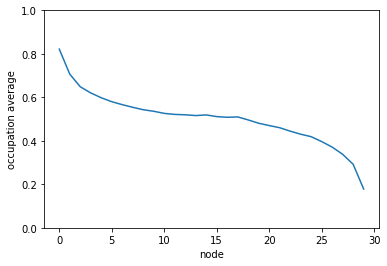

In [45]:
L =30 #@param slider {type:"slider", min:3, max:100, step:1}
kin = 0.431 #@param slider {type:"slider", min:0.001, max:0.5, step:0.01}
kout = 0.431 #@param slider {type:"slider", min:0.001, max:0.5, step:0.01}
kstep = 0.291 #@param slider {type:"slider", min:0.001, max:0.5, step:0.01}

t = np.linspace(0,1000,1001)
xi =np.zeros(L)

def get_lattice_density(traj_soln):
  return np.mean(traj_soln,axis=1)
t = np.linspace(0,100000,100001)
traj,n_particles = tasep_traj_ex(xi,kin,kout,kstep,t,exclusion=1)
x = get_lattice_density(traj)
plt.plot(x)
plt.ylim([0,1])
plt.ylabel('occupation average')
plt.xlabel('node')

Text(0.5, 0, 'node')

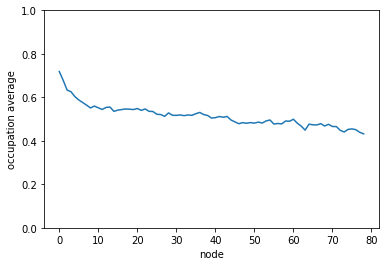

In [51]:
L =79 #@param slider {type:"slider", min:3, max:100, step:1}
alpha = 0.94 #@param slider {type:"slider", min:0.01, max:1, step:0.01}
beta = 0.59 #@param slider {type:"slider", min:0.01, max:1, step:0.01}

t = np.linspace(0,1000,1001)
xi =np.zeros(L)

def get_lattice_density(traj_soln):
  return np.mean(traj_soln,axis=1)
t = np.linspace(0,10000,10001)
traj,n_particles = tasep_traj_ex(xi,alpha,beta,1,t,exclusion=1)
x = get_lattice_density(traj)
plt.plot(x)
plt.ylim([0,1])
plt.ylabel('occupation average')
plt.xlabel('node')

In [52]:
import tqdm.notebook as tq
import time
n = 7 #@param slider {type:"slider", min:3, max:25, step:1}
t = np.linspace(0,5000,5001)
xi =np.zeros(L)
density_heatmap = np.zeros([n,n])
density_front_heatmap = np.zeros([n,n])
density_back_heatmap = np.zeros([n,n])
n_particles_heatmap = np.zeros([n,n])
computation_time_heatmap = np.zeros([n,n])
xx,yy = np.meshgrid(np.linspace(0.05,1,n), np.linspace(0.05,1,n))
with tq.tqdm(total=n**2) as pbar:
  for i in range(n):
    for j in range(n):
      st = time.time()
      traj,particles = tasep_traj_ex(xi,xx[i,j],yy[i,j],1,t,exclusion=1)
      traj_density_profile = get_lattice_density(traj)

      density_heatmap[i,j] = np.mean(traj)
      density_front_heatmap[i,j] = np.mean(traj[:3])
      density_back_heatmap[i,j] = np.mean(traj[-3:])
      n_particles_heatmap[i,j] = particles/t[-1]
      computation_time_heatmap[i,j] = time.time()-st
      pbar.update(1)


  0%|          | 0/49 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Flow (particles/s)')

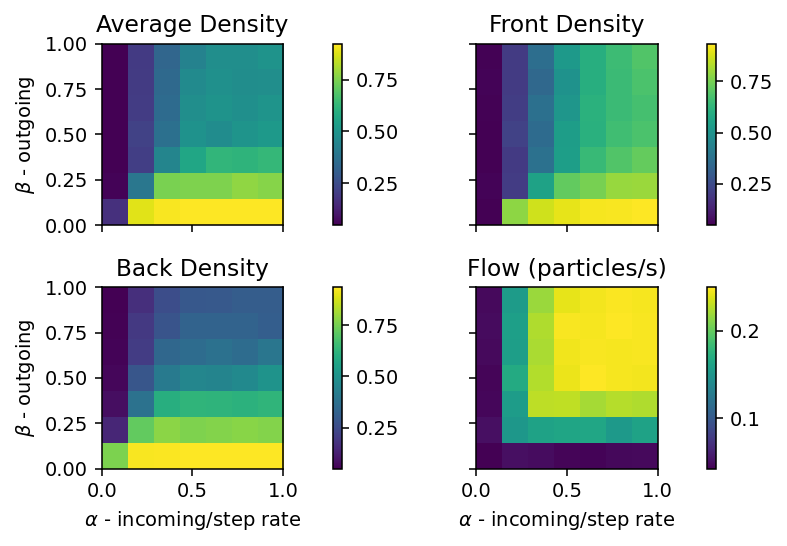

In [53]:
fig,ax = plt.subplots(2,2,tight_layout=True,dpi=140,sharey=True,sharex=True)

cax3 = ax[0,0].imshow(np.flipud(density_heatmap),extent=[0,1,0,1])
cax4 = ax[0,1].imshow(np.flipud(density_front_heatmap),extent=[0,1,0,1])
cax = ax[1,0].imshow(np.flipud(density_back_heatmap),extent=[0,1,0,1])
cax2 = ax[1,1].imshow(np.flipud(n_particles_heatmap),extent=[0,1,0,1])
fig.colorbar(cax2,shrink=1,pad=.13,ax=ax[1,1])
fig.colorbar(cax,shrink=1,pad=.13,ax=ax[1,0])
fig.colorbar(cax3,shrink=1,pad=.13,ax=ax[0,0])
fig.colorbar(cax4,shrink=1,pad=.13,ax=ax[0,1])
ax[1,1].set_xlabel(r'$\alpha$ - incoming/step rate')
ax[1,0].set_xlabel(r'$\alpha$ - incoming/step rate')
ax[0,0].set_ylabel(r'$\beta$ - outgoing')
ax[1,0].set_ylabel(r'$\beta$ - outgoing')

ax[0,0].set_title(r'Average Density')
ax[0,1].set_title(r'Front Density')
ax[1,0].set_title(r'Back Density')
ax[1,1].set_title(r'Flow (particles/s)')

Text(0.5, 1.0, 'Time (s)')

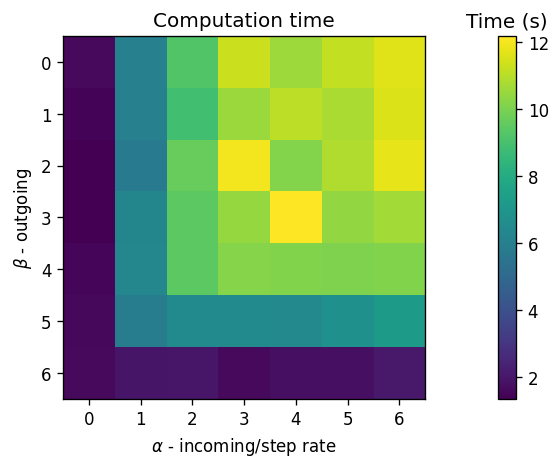

In [55]:
fig,ax = plt.subplots(1,1,dpi=120)
cax = ax.imshow(np.flipud(computation_time_heatmap))
cbar = fig.colorbar(cax,shrink=1,pad=.13,ax=ax)

ax.set_xlabel(r'$\alpha$ - incoming/step rate')
ax.set_ylabel(r'$\beta$ - outgoing')
ax.set_title('Computation time')
cbar.ax.set_title('Time (s)')

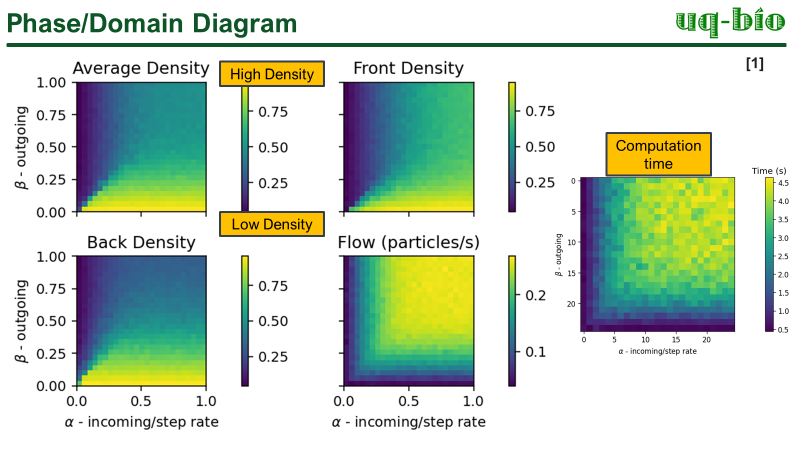

Above is a higher resolution simulation of the domains of the canonical TASEP. You can see the hard boundary between LD and HD and soft boundary towards maximum flow! 

Additionally, with this stochastic process, the more events simulated the longer this trajectory takes to compute. Maximal current is almost 10x longer to simulate than high density (everyone is stuck in place for a long period of time).

## rSNAPsim

Rna Sequence to NAscent Protein Simulation - This is a python package that implements a codon dependent tasep for a given mRNA transcript, specifically for fitting nascent chain tracking data. The underlying code is one we have already seen! mRNA is modelled as a lattice where each node is a codon, with a given stepping rate for each of hte 61 sense codons, and a particle (ribosome) exclusion of 9 codons (ribosomal footprint).


https://github.com/MunskyGroup/rSNAPsim/tree/packaged


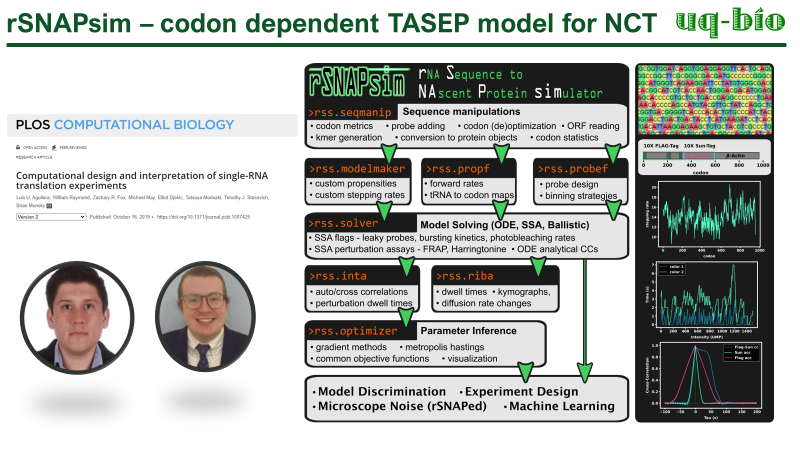

In [54]:
#@title Installing rsnapsim (this will take a minute)
%%capture
## Install rsnapsim and its c++ package
!pip install biopython
!apt install libeigen3-dev
!ln -sf /usr/include/eigen3/Eigen /usr/include/Eigen
!pip install rsnapsim-ssa-cpp
!pip install rsnapsim
#making sure we are up to date 100%
!pip install --upgrade rsnapsim 

### Getting a gene file into a usable format

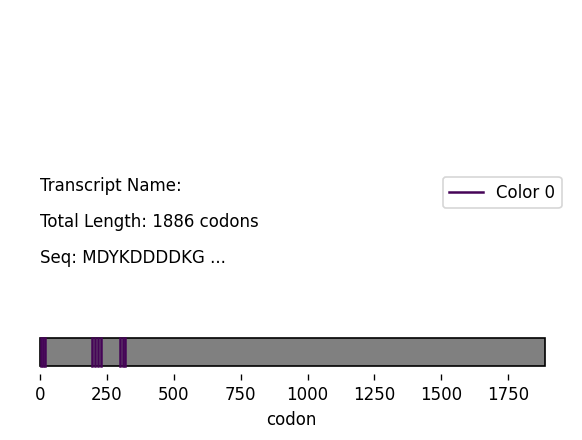

In [56]:
# Downloading a KDM5B gene sequence to simulate translation dynamics.
import urllib.request as request
urls = ['https://github.com/MunskyGroup/uqbio2021/raw/main/module_3/Presentation_for_project3/KDM5B_withTags.txt'] # loading gene sequence
print('Downloading gene file...')
request.urlretrieve(urls[0], './KDM5B_withTags.txt')
KDM5B_gene_file = './KDM5B_withTags.txt'  #path to our file

import rsnapsim as rsim  #import the rsnapsim

poi_strs, poi_objs, tagged_pois,raw_seq = rsim.seqmanip.open_seq_file(KDM5B_gene_file)  #open this file and find all valid protein of interest objs
kdm5b_mrna = tagged_pois['1'][0]  # lets take the first one since thats the longest open reading frame
kdm5b_mrna.visualize_probe()  # what does our construct look like?

In [57]:
#just checking out some of the sequences from that kdm5b text file
print(kdm5b_mrna.nt_seq)
print(kdm5b_mrna.aa_seq)

AUGGACUACAAGGACGACGACGACAAAGGUGACUACAAAGAUGAUGACGAUAAAGGCGACUAUAAGGACGAUGACGACAAGGGCGGAAACUCACUGAUCAAGGAAAACAUGCGGAUGAAGGUGGUGAUGGAGGGCUCCGUGAAUGGUCACCAGUUCAAGUGCACCGGAGAGGGAGAGGGAAACCCGUACAUGGGAACUCAGACCAUGCGCAUUAAGGUCAUCGAAGGAGGUCCGCUGCCGUUCGCUUUCGAUAUCCUGGCCACUUCGUUCGGAGGAGGGUCGCGCACGUUCAUCAAGUACCCGAAGGGAAUCCCGGACUUCUUUAAGCAGUCAUUCCCGGAAGGAUUCACUUGGGAACGGGUGACCCGGUAUGAAGAUGGAGGUGUGGUGACUGUCAUGCAAGAUACUUCGCUGGAGGAUGGGUGCCUCGUGUACCACGUCCAAGUCCGCGGAGUGAAUUUCCCGUCCAACGGACCAGUGAUGCAGAAAAAGACGAAGGGUUGGGAACCUAAUACUGAAAUGAUGUACCCCGCAGACGGAGGGCUGAGGGGCUACACCCACAUGGCGCUGAAGGUCGACGGAGGAGAUUACAAGGAUGACGACGAUAAGCAACAAGAUUACAAAGACGAUGAUGACAAGGGCCAGCAGGGCGACUACAAGGACGACGACGACAAGCAGCAGGACUACAAAGAUGACGAUGAUAAAGGAGGAGGACAUCUGUCCUGUUCGUUCGUGACCACCUACAGAUCAAAGAAAACCGUGGGAAACAUCAAGAUGCCGGGCAUUCAUGCCGUCGACCACCGCCUGGAGCGGCUCGAAGAAUCAGACAAUGAGAUGUUCGUCGUGCAAAGAGAACAUGCCGUGGCCAAGUUCGCGGGACUGGGAGGCGGUGGAGGCGAUUACAAAGACGAUGAUGACAAGGGUGACUAUAAAGACGACGAUGACAAAGGGGAUUACAAGGAUGAUGAUGAUAAGGGAGGCGGUGGAUCAGGUGGAGGAG

Running a codon dependent TASEP simulation

In [58]:
ke = 10  #average forward rate
ki = .03  #in rate
t = np.linspace(0,1000,1001) #time array
kdm5b_mrna.ke_mu = ke  #set the protein objects average rate (this recalculates its kelong's)
ssa_soln = rsim.solver.solve_ssa(kdm5b_mrna.kelong,t,ki=ki,kt=10, low_memory=False,n_traj = 1, 
                                 probe_loc=kdm5b_mrna.probe_loc,
                                 probe_vec=kdm5b_mrna.probe_vec) #pass to the solver

In [59]:
ssa_soln.ribosome_locations[0].shape

(1001, 10)

What did we get out of our simulation? 

Well we got a condensed position vector over time: 

$(N Trajectory, Time, max(ribosomes))$

We also got the spot intensity (sum of all passed probes) of shape:

$(N trajectories, Time, Ncolors)$


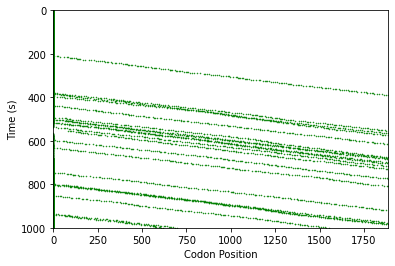

In [60]:
import matplotlib.pyplot as plt
f, ax = plt.subplots()

#Funky data manipulation to plot it in a kymograph 
ax.plot(np.fliplr(ssa_soln.ribosome_locations[0]),'.', markersize=1, color='green')
for i in range(len(ax.lines)):
  newx = ax.lines[i].get_ydata()
  newy = ax.lines[i].get_xdata()

  # set new x- and y- data for the line
  ax.lines[i].set_xdata(newx)
  ax.lines[i].set_ydata(newy)
ax.set_xlim([0, kdm5b_mrna.total_length])
ax.set_ylim([0, t[-1]])

ax.set_xlabel('Codon Position')
ax.set_ylabel('Time (s)')
f.gca().invert_yaxis()

Text(0, 0.5, 'Intensity (ump)')

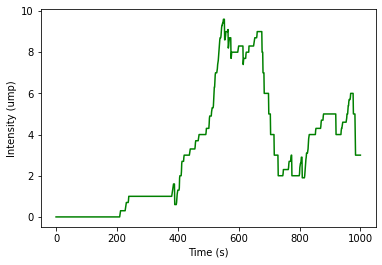

In [61]:
plt.plot(ssa_soln.intensity_vec[0]/10, 'g')
plt.xlabel('Time (s)')
plt.ylabel('Intensity (ump)')

### What are the Stepping rates based on?

As a default, the codon dependent rates, ie the speed at which a ribosome moves forward from codon N is based on the Human CCDS frequency from the 2007 flat release. 

Codon frequency bias makes the following assumption: the more frequent a codon in coding regions of a species genome, the faster it is translated. In the rSNAPsim we use these rates to scale an average ribosomal kelongation rate based on the average frequency. If the codon is more frequent than the average, the stepping rate will be higher than the set average ke, and vice versa.

----

$ k_e(i) = \bar{k_e} * (u(i) / \bar{u}) $

where 

$ k_e(i) $ = stepping rate at position $i$

$ \bar{k_e} $ = set mean stepping rate

$ u(i) $ = codon frequency of codon at position $i$

$ \bar{u} $ = average codon frequency of all codons



In [62]:
print(rsim.cdict.human_codon_frequency_bias_nakamura)


{'TTT': 17.6, 'TCT': 15.2, 'TAT': 12.2, 'TGT': 10.6, 'TTC': 20.3, 'TCC': 17.7, 'TAC': 15.3, 'TGC': 12.6, 'TTA': 7.7, 'TCA': 12.2, 'TAA': 1.0, 'TGA': 1.6, 'TTG': 12.9, 'TCG': 4.4, 'TAG': 0.8, 'TGG': 13.2, 'CTT': 13.2, 'CCT': 17.5, 'CAT': 10.9, 'CGT': 4.5, 'CTC': 19.6, 'CCC': 19.8, 'CAC': 15.1, 'CGC': 10.4, 'CTA': 7.2, 'CCA': 16.9, 'CAA': 12.3, 'CGA': 6.2, 'CTG': 39.6, 'CCG': 6.9, 'CAG': 34.2, 'CGG': 11.4, 'ATT': 16.0, 'ACT': 13.1, 'AAT': 17.0, 'AGT': 12.1, 'ATC': 20.8, 'ACC': 18.9, 'AAC': 19.1, 'AGC': 19.5, 'ATA': 7.5, 'ACA': 15.1, 'AAA': 24.4, 'AGA': 12.2, 'ATG': 22.0, 'ACG': 6.1, 'AAG': 31.9, 'AGG': 12.0, 'GTT': 11.0, 'GCT': 18.4, 'GAT': 21.8, 'GGT': 10.8, 'GTC': 14.5, 'GCC': 27.7, 'GAC': 25.1, 'GGC': 22.2, 'GTA': 7.1, 'GCA': 15.8, 'GAA': 29.0, 'GGA': 16.5, 'GTG': 28.1, 'GCG': 7.4, 'GAG': 39.6, 'GGG': 16.5, 'UUU': 17.6, 'UCU': 15.2, 'UAU': 12.2, 'UGU': 10.6, 'UUC': 20.3, 'UCC': 17.7, 'UAC': 15.3, 'UGC': 12.6, 'UUA': 7.7, 'UCA': 12.2, 'UAA': 1.0, 'UGA': 1.6, 'UUG': 12.9, 'UCG': 4.4, 'U

What if we induce a pause?

Since this package takes any set of stepping rates's we can easily edit specific rates or tRNA and see the effects,

Lets induce a pause at some arbitrary location.

/usr/local/lib/python3.7/dist-packages/rsnapsim/TranslationSolvers.py:876: UserWarning: no provided probe vector, using a blank probe. This will result in zero sum intensity.
  warnings.warn('no provided probe vector, using a blank probe'\


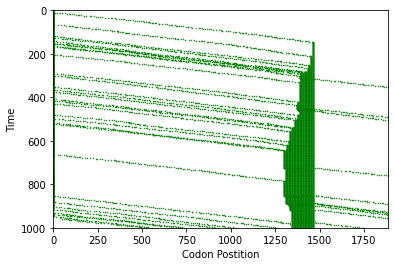

In [63]:
#@title run kymograph
pause_location = 1460 #@param {type:"slider", min:0, max:1500, step:1}

ke = 10  #average stepping rate
ki = .03  #incoming rate
t = np.linspace(0,1000,1001) # time vector

kdm5b_mrna.ke_mu = ke  #set the average rate
kelong_induced_pause = np.array(kdm5b_mrna.kelong).tolist() #get a copy of the original rates

kelong_induced_pause[pause_location] = .01 #lower the stepping rate at position 1000

#Solve the ssa
ssa_soln = rsim.solver.solve_ssa(kelong_induced_pause,t,ki=ki,kt=10, low_memory=False,n_traj = 1)

f, ax = plt.subplots()
#Funky data manipulation to plot it in a kymograph 
ax.plot(np.fliplr(ssa_soln.ribosome_locations[0]),'.',markersize=1,color='green')
for i in range(len(ax.lines)):
  newx = ax.lines[i].get_ydata()
  newy = ax.lines[i].get_xdata()

  # set new x- and y- data for the line
  ax.lines[i].set_xdata(newx)
  ax.lines[i].set_ydata(newy)
ax.set_xlim([0, kdm5b_mrna.total_length])
ax.set_ylim([0, t[-1]])
ax.set_xlabel('Codon Postition')
ax.set_ylabel('Time')
f.gca().invert_yaxis()



Like wise we can reduce the rate of all of one species of codon

In [66]:

new_rate = 0.188  #@param slider {type:"slider", min:0.001, max:5, step:0.001}
codon = "GGG" #@param ["CAG", "TTT", "GCC", "GGG"] {allow-input: true}

#get all codon indicies in the mRNA
codon_inds = [i for i,x in enumerate( kdm5b_mrna.codons) if x == codon]
print( 'total %s in mrna: %i '% (codon, len(codon_inds)))
print( 'default rate of codon %s: %f' % (codon, rsim.cdict.human_codon_frequency_bias_nakamura[codon]))

kelong_induced_rare_codon = np.array(kdm5b_mrna.kelong).tolist() #copy the stepping rates
for c_ind in codon_inds:  #for all found codons, set them to the new rate
  kelong_induced_rare_codon[c_ind] = new_rate


total GGG in mrna: 18 
default rate of codon GGG: 16.500000


/usr/local/lib/python3.7/dist-packages/rsnapsim/TranslationSolvers.py:876: UserWarning: no provided probe vector, using a blank probe. This will result in zero sum intensity.
  warnings.warn('no provided probe vector, using a blank probe'\


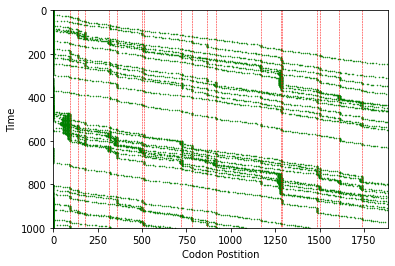

In [67]:
#@title run kymograph
ke = 10  #average ke
ki = .03 #incoming rate
t = np.linspace(0,1000,1001)  #time vector
kdm5b_mrna.ke_mu = ke

#solve the simulation with the new propensities
ssa_soln = rsim.solver.solve_ssa(kelong_induced_rare_codon,t,ki=ki,kt=10, low_memory=False,n_traj = 1)

f, ax = plt.subplots()
#Funky data manipulation to plot it in a kymograph 
ax.plot(np.fliplr(ssa_soln.ribosome_locations[0]),'.',markersize=1,color='green')
for i in range(len(ax.lines)):
  newx = ax.lines[i].get_ydata()
  newy = ax.lines[i].get_xdata()

  # set new x- and y- data for the line
  ax.lines[i].set_xdata(newx)
  ax.lines[i].set_ydata(newy)
ax.set_xlim([0, kdm5b_mrna.total_length])
ax.set_ylim([0, t[-1]])
for c_ind in codon_inds:
  plt.plot([c_ind,c_ind],[0,t[-1]],'r--',lw=.5)


ax.set_xlabel('Codon Postition')
ax.set_ylabel('Time')
f.gca().invert_yaxis()


## rSNAPed

How do we use these trajectories to recapture real NCT experiments?

**See Luis's Poster!**

We can take our intensity trajectories and convert them to video spots using a point spread function. Then combining these with brownian motion and blank cell backgrounds we can create realistic simulated NCT videos!

Below we have 54 trajectories simulated by 7 different codon dependent TASEPs for 7 different genes. Each simulation in this video has the same elongation and initiation parameters, the only variable that changes is the length and codon usage of the respective genes.

| Gene      | RRAGC | LORNF2 | MAP3K6 | DOCK8 | ORC2 | TRIM33 | PHIP |
| ----------- | ----------- | ------ | ------ | ------ | ------ | ------ | ------ |
| Length (NT)     |  1200      | 2265 | 3867 | 6000 | 1734 | 3333  | 5466 |
| Channel   | G        | G        | G        | G        | B|B|B|

By spacing these out we have created a theoretical tagging regime that has multiple transcript species tagged in the same color such that they are still differentiable to later statistical / ML analysis.

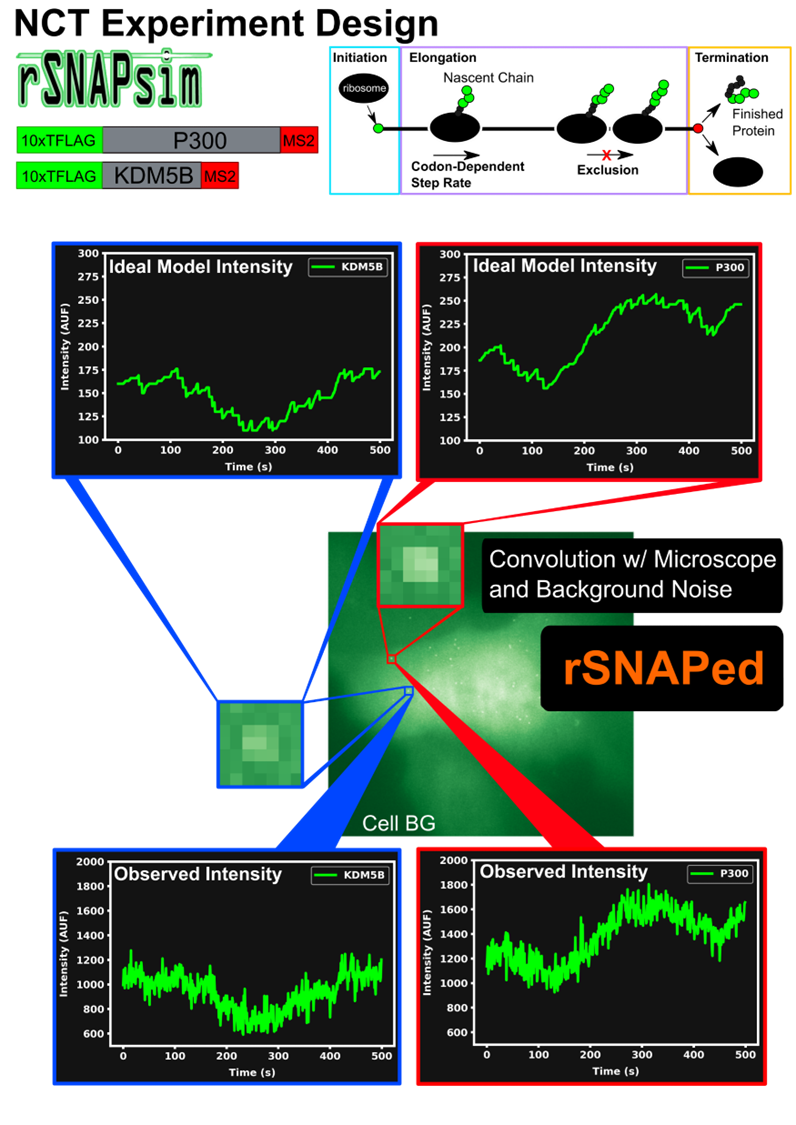

In [68]:
#@title Rsnaped Example video display
from IPython.display import HTML
from base64 import b64encode
import os

!wget -nc https://raw.githubusercontent.com/MunskyGroup/uqbio2022/master/files/files_tasep/Example_mulitplexing_2.mp4

mp4 = open('Example_mulitplexing_2.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1200 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

--2022-06-10 17:27:07--  https://raw.githubusercontent.com/MunskyGroup/uqbio2022/master/files/files_tasep/Example_mulitplexing_2.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1686816 (1.6M) [application/octet-stream]
Saving to: ‘Example_mulitplexing_2.mp4’

Example_mulitplexin 100%[===================>]   1.61M  --.-KB/s    in 0.04s   

2022-06-10 17:27:07 (40.6 MB/s) - ‘Example_mulitplexing_2.mp4’ saved [1686816/1686816]



## Model Builder

The current rsnapsim version (as of writing 0.0.55) comes with a module that builds and compiles arbitrary C++ TASEP models for use in python. **THIS CODE IS A WORK IN PROGRESS** this code is going to be updated soon to add an additional type of reaction so this will be missing a section soon. Aslo this code can only compile ONE MODEL AT A TIME, compiling multiple or using multiple at a time will crash your kernel.


Additional Reactions are split into 2 parts:
* Lattice affecting reactions
* State affecting reactions

Lattice affecting reactions include things like ribosomes entering/leaving the mRNA strand 

State affecting reactions allow for any constant "state" of the mRNA. For example, you could define two states, state 1 where the mRNA is uncircularized and state 2 where the mRNA is circularized, causing a faster initation rate. The mRNA can be in one of those states at a time.

-----------------------------------------------

1. define number of states
2. define number of lattice changing reactions (in/out)
3. define the stoichiometry between states
4. define the stoichiometry of the lattice
5. define forward rates

6. define the additional rule logic 
7. compile the model




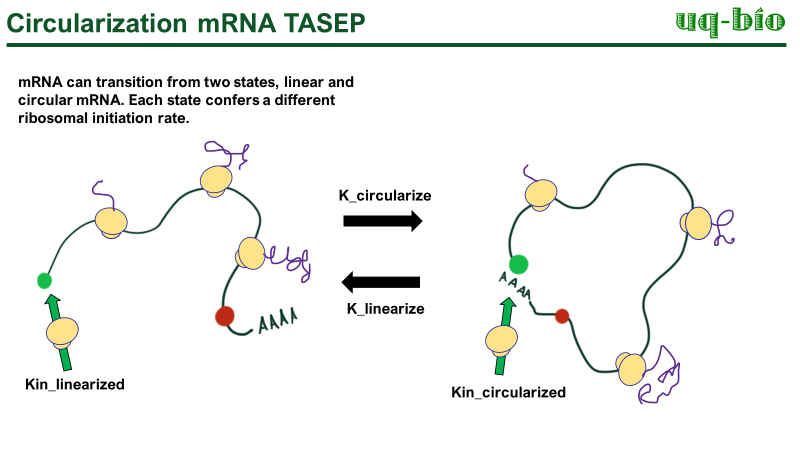

In [69]:
#@title Circularization Model building code 

########### Parameter setup ###########
k_circularize = .004
k_linearize = .02
kin_circularized = .013 # rate to 
kin_linear = .002
kout = 10

construct_end = len(kdm5b_mrna.kelong)
parameters = np.array([k_circularize, k_linearize,
                       kin_circularized, kin_linear,
                       construct_end], dtype=float)

########### Forward TASEP rates ###########
forward_rates = kdm5b_mrna.kelong + [0,] #forward rates of the construct (with an extra 0 at the end)


########### Stoichiometry for state reactions ###########
#stoichiometry for the states  
# we have 2 states the mRNA can be in in our case:
#     hairpin formed
#     hairpin not formed 
stoich_states = np.array([[-1,  1,  ],
                          [ 1,  -1,  ],], dtype = np.int32)

########### Stoichiometry for lattice reactions ###########
# we have 2 reactions in our case:
#     ribosomes entering at the start of the lattice (start codon)
#     ribosomes leaving at the end of the lattice (stop codon)
#stoichiometry for the lattice ractions
stoich_lattice = np.zeros([3,len(forward_rates)], dtype=np.int32)
stoich_lattice[0,0] = 1 #entering at rate 1
stoich_lattice[1,0] = 1 #entering at rate 2
stoich_lattice[2,-1] = -1 #leaving

########### Initial States of the states and lattice ###########
xi_states = np.array([[1,0]], dtype= np.int32)
xi_lattice = np.zeros([1,len(forward_rates)], dtype=np.int32)


additional_rules_2 = '''
#               0                 1               2             3         4       5  
#parameters = [k_circularize, k_linearize, kin_circularized, kin_linear, kout, end_loc]

#propensity function for hairpin model

#### Define extra parameters in C 
int end_loc = cast_to_int(parameters[5]) #end of the construct
int l = X[1886] #overwrite to min_length
#### define state related reactions



if state[0] == 1:
    #circularized
    wn[1] = parameters[1]  #add k_linearize
    
if state[0] == 0:
    #linearized
    wn[0] = parameters[0] #add k_circularize

#### lattice related reactions (ribosomes entering and leaving)

if free[0]:
    if state[0] == 1:
        wn[2] = parameters[2]
    if state[1] == 1:
        wn[3] = parameters[3]

if X[end_loc] == 1:
    # if its in the final location, add kout
    step[end_loc] = 0
    wn[4] = parameters[4]

'''

#compile the model and load it back in
rsim.model_builder.compile_model('circle_model', overwrite=True, rules=additional_rules_2,
                                eigen_path='/usr/include/Eigen')
circularization_model = rsim.model_builder.get_model('circle_model')


parsing rules...
generating model files...
replacing_prop...
compiling model...
model compiled!


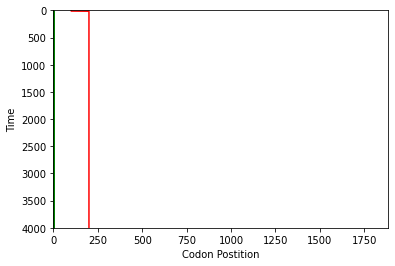

In [71]:
#@title solve circle model
k_circularize = 0.201 #@param {type:"slider", min:0.001, max:10, step:0.1}
k_linearize = 0.141 #@param {type:"slider", min:0.001, max:10, step:0.01}
kin_circularized = 0.08 #@param {type:"slider", min:0.001, max:0.08, step:0.001}
kin_linear = 0.002 #@param {type:"slider", min:0.001, max:0.03, step:0.001}
kout = 11.7 #@param {type:"slider", min:0.1, max:30, step:0.1}

construct_end = len(kdm5b_mrna.kelong)

parameters = np.array([k_linearize,k_circularize,
                       kin_circularized, kin_linear, kout,
                       construct_end], dtype=float)

t_array = np.linspace(0,4000,4001)
n_traj = 1

ssa_soln = rsim.solver.solve_custom_model(circularization_model, parameters, forward_rates, t_array,
                           stoich_lattice, stoich_states,
                           xi_lattice, xi_states, n_traj=n_traj,
                           probe_loc=kdm5b_mrna.probe_loc, poi=None)


f, ax = plt.subplots()
#Funky data manipulation to plot it in a kymograph 
ax.plot(np.fliplr(ssa_soln.ribosome_locations[0]),'.',markersize=1,color='green')
ax.plot(ssa_soln.states[0][:,0]*100,'r')
for i in range(len(ax.lines)):
  newx = ax.lines[i].get_ydata()
  newy = ax.lines[i].get_xdata()

  # set new x- and y- data for the line
  ax.lines[i].set_xdata(newx)
  ax.lines[i].set_ydata(newy)
ax.set_xlim([0, kdm5b_mrna.total_length])
ax.set_ylim([0, t_array[-1]])

ax.set_xlabel('Codon Postition')
ax.set_ylabel('Time')
f.gca().invert_yaxis()

## Questions

For credit, answer 5 out of the 6 easy questions + and try least one of the harder questions!



#### Easy Questions

Q1 - Explain the phase domains of the canonical TASEP model

Q2 - What regimes will approximate ballistic motion of particles? i.e. the mean waiting time is just the sum of all individual lattice waiting times. When does this assumption start to fail?

Q3 - List out several things a TASEP model could be used to simulate other than the ones listed above (Traffic, mRNA, electrophoresis, Vesicle transport)

In [ ]:
# Q1 Adjust the induced pause TASEP model to have two pauses, one at 1/3 of the distance and one at
#    2/3 of the distance along the gene.  Make histograms when (1) the first pause is longer than the
#    second, (2) when the second pause is longer than the first and (3) when both pauses are the same.
#    Comment on the difference in the kymographs.

# Q2 Take the arbitrary stepping rate TASEP code and create kymographs for the following 
#    sets of arbitrary rates: 
#         1. 10% of the lattice nodes are slower than the average lattice node in random locations
#         2. One extremely slow lattice node near the front of the lattice
#         3. rates that ramp up to a value over the first half of the lattice


# Q2.b Write a code that simulates the tasep 500 times and makes a
#      histogram of occupation probability at the final simulation time point over the 500
#      simulations. Use this code on each case in Question 2. Comment on the occupation probability trends.

#### Harder Questions

In [ ]:
#Q1 Take one of the codes above and adjust them for Langmuir kinetics

### RULES ###
# Particles are allowed to bind to a 1D lattice of size N at a rate K_bind
# Particles can step either direction along the 1D lattice as long as the forward site is free of exclusion
# Particles step at a rate K_step
# Particles leave from any node at a rate K_unbind
# Particles can leave either end of the lattice at a rate of k_step but can not rejoin
# Particles can enter any empty edge nodes at a rate of kstep*kbind


#Q1.a
# Derive the average distance traveled by a particle assuming there is no exclusion

#Q1.b
# Calculate your simulated particles' average distance traveled, how does it match up?

#Q1.c 
# What combination of parameters lead to crowded loading conditions, and which combinations lead to sparse loading?




In [ ]:
#Q2 Take your Langmuir kinetic TASEP and extend it to 2D

### RULES ###
# Particles are allowed to bind to a 2D lattice of size NxM at a rate K_bind
# Particles can step either direction along the 2D lattice as long as the forward site is free of exclusion
# Particles CAN move diagonally at K_step
# Particles step at a rate K_step
# Particles leave from any node at a rate K_unbind
# Particles can leave either edge node of the lattice at a rate of k_step but can not rejoin
# Particles can enter any empty edge nodes at a rate of K_step*K_bind


#Q2.a
# Write a function to calculate the average occupation of your NxM lattice 

#Q2.b
# Predict the relationship of average occupation and (K_bind/K_unbind) with a constant K_step
# Plot the true relationship to check your prediction.

#Q2.c 
# Write a function / add a recorder to your simulation to get the distance traveled of each particle 

#Q2.d
# Write a function / add a recorder to your simulation to get the dwelltimes of how long a particle is bound to the lattice

#Q2.e
# Plot the distribution of individual particles distances traveled over several different ratios of
# (K_bind/K_unbind).

#Q2.f (BONUS)
# Create an animation of a 2d simulation trajectory


In [ ]:
#Q3 Take your Langmuir kinetic 2D TASEP and add the following rule:

# Particles that are adjacent to one another introduce a new rate K_react
# If the simulation selects this reaction, both particles are destroyed/leave the lattice

# SUGGESTION: Set the K_react to much greater than K_step

#Q3.a
# Write a function to record/calculate how many reactions occur in a given timespan 

#Q3.b
# Plot the relationship of reactions per time and particle dwell time for several different K_step values.

## Discussion Questions

* What happens if you bin nodes together?
* Can you think of any extensions other than the ones we discussed?



## Reading


Just a couple papers on some tasep models, some examples of what these types of papers typically look like and what you can do with them

-------------------------
TASEP Papers
--------------------------------------
------------------------------------

[1] Zia RKP, Dong JJ, Schmittmann B. *Modeling Translation in Protein Synthesis with TASEP: A Tutorial and Recent Development.* Journal of Statistical Physics. **144** (2011) https://doi.org/10.1007/s10955-011-0183-1

[2] Denisov DV, Miedema DM, Nienhuis B, Schall P. *Totally asymmetric simple exclusion process simulations of molecular motor transport on random networks with asymmetric exit rates.* Physical Review E. **92** (2015) https://doi.org/10.1103/PhysRevE.92.052714

[3] Yuan YM, Jiang R, Wang R, Hu MB, Wu QS. *Totally asymmetric simple exclusion process with a shortcut*. J. Phys A: Mathmatical and Theoretical. **40** (2007) http://dx.doi.org/10.1088/1751-8113/40/41/006

[4] Parmeggiani A, Franosch T, Frey E. *The Totally Asymmetric Simple Exclusion Process with Langmuir Kinetics.* Physical Review E. **70** (2004) https://doi.org/10.1103/PhysRevE.70.046101


-------------------------
Rsnapsim and Nascent Chain Tracking Papers
--------------------------------------
------------------------------------
[5] Aguilera L, et al. *Computational design and interpretation of single-RNA translation experiments.* PLOS computational biology. **15(10)** (2019) https://doi.org/10.1371/journal.pcbi.1007425  

[6] Koch, A., Aguilera, L., Morisaki, T. et al. *Quantifying the dynamics of IRES and cap translation with single-molecule resolution in live cells.* Nat Struct Mol Biol **27**, 1095–1104 (2020). https://doi.org/10.1038/s41594-020-0504-7

[7] Morisaki, T., Müller, W., Golob, N. et al. *Single-molecule analysis of transcription factor binding at transcription sites in live cells.* Nat Commun 5, 4456 (2014). https://doi.org/10.1038/ncomms5456

[8] Lyon K et al. *Live-Cell Single RNA Imaging Reveals Bursts of Translational Frameshifting.* Molecular Cell. 75(1) (2019). https://doi.org/10.1016/j.molcel.2019.05.002 